In [36]:
import pandas as pd
import numpy as np
from statsmodels.nonparametric.smoothers_lowess import lowess
import matplotlib.pyplot as plt
from adjustText import adjust_text

import statsmodels.api as sm


import warnings
warnings.filterwarnings("ignore")

# Load unseen-species model data
#path = 'unseen_species_model/unseen_species_model.csv'
#path = 'unseen_species_model/unseen_species_model_no_occupation.csv'
path = 'unseen_species_model/unseen_species_model_bayesian.csv'


df_cultura_original = pd.read_csv(path, index_col = [0])
df_cultura_original

,individual_wikidata_id,decade,region_name,count_works,occupation,century,count,y,y_mean,y_min,y_max,f0,max_f0,min_f0,f1,f2
0,Q1000034,1850,German world,0.0,Writer,1800,0.0,0,0.026322,0.025143,0.027497,18.008463,18.898832,17.197598,1,0
2,Q1000034,1850,Northwestern Europe,0.0,Writer,1800,0.0,0,0.039378,0.038297,0.040462,11.717243,12.074992,11.377598,1,0
5,Q100022441,1770,France,0.0,Performing Artist,1800,0.0,0,0.043535,0.039614,0.047476,10.506729,11.641732,9.555465,1,0
6,Q100022441,1770,Northwestern Europe,0.0,Performing Artist,1800,0.0,0,0.035473,0.032444,0.038573,13.113081,14.427312,11.981839,1,0
9,Q100028706,1880,Italy,0.0,Musician,1900,0.0,0,0.004629,0.004096,0.005170,107.026430,121.076616,95.720245,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
474175,Q99982212,1880,Central Europe,0.0,Architect,1900,0.0,0,0.012460,0.011082,0.013919,39.133367,44.122022,34.928435,1,0
474181,Q999920,1790,German world,2.0,Painter,1800,2.0,1,0.069045,0.066096,0.072048,6.276144,6.597781,5.975854,0,1
474182,Q999920,1790,Northwestern Europe,2.0,Painter,1800,2.0,1,0.101092,0.098283,0.103914,3.996555,4.136472,3.863650,0,1
474184,Q999983,1340,France,0.0,Writer,1300,0.0,0,0.071291,0.065518,0.077156,6.049192,6.664265,5.518959,1,0


In [37]:

#df_cultura_original = df_cultura_original.rename(columns = {'f0_min':'min_f0', 'f0_max':'max_f0'})

df_cultura_original['N_est'] = df_cultura_original['f0'] + df_cultura_original['f1'] + df_cultura_original['f2']# plus the individual
df_cultura_original['N_est_min']  =  df_cultura_original['min_f0'] + df_cultura_original['f1'] + df_cultura_original['f2']# plus the individual
df_cultura_original['N_est_max']  =  df_cultura_original['max_f0'] + df_cultura_original['f1'] + df_cultura_original['f2']# plus the individual

df_cultura = df_cultura_original.groupby(['region_name', 'decade']).agg({'N_est': 'sum', 'N_est_min':'sum', 'N_est_max':'sum', 'individual_wikidata_id':'count'}).reset_index()
df_cultura = df_cultura.rename(columns={"individual_wikidata_id": "score"})

# Load individuals Data
df_individuals = pd.read_csv('db_extract/df_individuals_score.csv', index_col = [0])

# Add indiviudals not taken into account into the unseen-species model
df_works = pd.read_csv('db_extract/df_indi__work>2.csv', index_col=[0])
df_works = df_works.groupby(['decade', 'region_name'])['individual_wikidata_id'].count().reset_index()
df_works = df_works.rename(columns = {'individual_wikidata_id':'f>3'})

df_cultura = pd.merge(df_cultura, df_works, on = ['region_name', 'decade'], how='left')
df_cultura = df_cultura.fillna(0)


df_cultura['N_est'] = df_cultura['N_est'] + df_cultura['f>3']
df_cultura['N_est_min'] = df_cultura['N_est_min'] + df_cultura['f>3']
df_cultura['N_est_max'] = df_cultura['N_est_max'] + df_cultura['f>3']
df_cultura['score'] = df_cultura['score'] + df_cultura['f>3']

In [38]:
#df_cultura.to_csv('unseen_species_model/estimates.csv')

In [39]:
list(set(df_individuals.region_name))

['Northwestern Europe',
 'Indian world',
 'Southern Japan',
 'Nordic countries',
 'South East Asia',
 'Iceland',
 'France',
 'Spain',
 'Ottoman world',
 'East Slavic',
 'Latin World',
 'Japan',
 'Eastern Europe',
 'Slav world',
 'Greece',
 'South America',
 'Central Europe',
 'Korea',
 'Western Europe',
 'Northern China',
 'Arabic world',
 'Denmark',
 'Persian world',
 'Balkans',
 'United Kingdom',
 'Southern France',
 'Central America',
 'Sweden',
 'British Islands',
 'Germany',
 'Northern Italy',
 'Yangtze',
 'Switzerland',
 'Greek World',
 'Africa',
 'Ireland',
 'Northern Japan',
 'German world',
 'Portugal',
 'Southern China',
 'Arabian peninsula',
 'Finland',
 'Ottoman Turkey',
 'Northern India',
 'Southwestern Europe',
 'Muslim world',
 'Norway',
 'Austria',
 'mediterranean World',
 'Southern India',
 'Italy',
 'North America',
 'Southern Italy',
 'Low countries',
 'Belgium',
 'Chinese world',
 'Netherlands',
 'Oceania',
 'Northern France']

### Make function

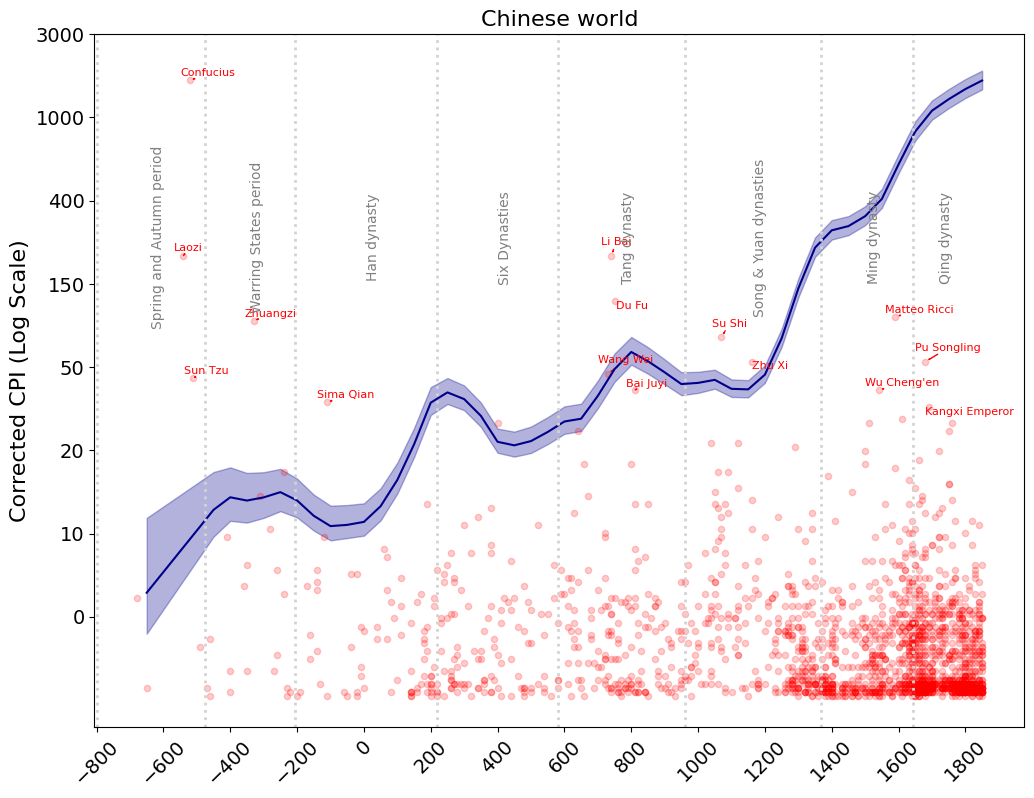

In [40]:
# Define a custom rounding function
def custom_round(x):
    if x >= 100000:
        return np.round(x, -5)  # Round to nearest 100000
    elif x >= 10000:
        return np.round(x, -4)  # Round to nearest 10000
    elif x >= 1000:
        return np.round(x, -3)  # Round to nearest 1000
    else:
        return np.round(x, -1)  # Round to nearest 10


def plot_figure(region_name, 
                max_year, 
                min_year, 
                period_data, 
                year_step = 200, 
                plot_names = True, 
                frac = 0.1, 
                top_n_individuals = 15,
                plot_bars = False,
                plot_original_trend = False,
                yticks = [5, 10, 50, 100, 500, 1000, 2000],
                fifty = False,
                log=True,
                legend=False):


    df_individuals_filtered = df_individuals[(df_individuals['decade']<=max_year)&(df_individuals['decade']>=min_year)]
    df_individuals_filtered = df_individuals_filtered[df_individuals_filtered['region_name'].isin([region_name])]
        

    df = df_cultura[df_cultura['region_name'].isin([region_name])]

    if fifty:
            df['decade'] = df['decade'].apply(lambda x: int(x) + (50 - int(x) % 50))
            df = df.groupby(['region_name', 'decade']).sum().reset_index()



    df = df[(df['decade'] <=max_year) & (df['decade']>=min_year)]

    if log:
        df['N_est'] = np.log(df['N_est'])  # Applying log transformation
        df['N_est_min'] = np.log(df['N_est_min'])  # Min bound log
        df['N_est_max'] = np.log(df['N_est_max'])  # Max bound log
        df['score'] = np.log(df['score'])  # Max bound log

    # Define your color scheme
    colors = {
        region_name: "#00008b",
    }

    fig, ax = plt.subplots(figsize=(12, 9))


    # List for storing text annotations for later adjustment
    texts = []

    # Calculate the maximum smoothed value for normalization
    max_n_est = float('-inf')

    # Adding smoothing and plotting for each region
    for region in df['region_name'].unique():
        region_data = df[df['region_name'] == region]
        region_data.sort_values(by='decade', inplace=True)


        # LOESS smoothing
        smoothed = sm.nonparametric.lowess(region_data['N_est'], region_data['decade'], frac=frac)
        smoothed_min = sm.nonparametric.lowess(region_data['N_est_min'], region_data['decade'], frac=frac)
        smoothed_max = sm.nonparametric.lowess(region_data['N_est_max'], region_data['decade'], frac=frac)

        # Update maximum n_est if current is higher
        max_n_est = max(max_n_est, max(smoothed[:, 1]))

        # Plotting the smoothed mean estimate
        ax.plot(smoothed[:, 0], smoothed[:, 1], label='Corrected CPI', color=colors[region])

        # Plotting the confidence interval as a fill between
        ax.fill_between(smoothed[:, 0], smoothed_min[:, 1], smoothed_max[:, 1], color=colors[region], alpha=0.3)

    # Calculate the maximum score for all individuals for normalization
    max_global_score = df_individuals_filtered['score'].max()


    if plot_original_trend:

            # Adding smoothing and plotting for each region
        for region in df['region_name'].unique():
            region_data = df[df['region_name'] == region]
            region_data.sort_values(by='decade', inplace=True)

                    # LOESS smoothing

            smoothed = sm.nonparametric.lowess(region_data['score'], region_data['decade'], frac=frac)
            # smoothed_min = lowess(region_data['N_est_min'], region_data['decade'], frac=0.2)
            # smoothed_max = lowess(region_data['N_est_max'], region_data['decade'], frac=0.2)
            # Update maximum n_est if current is higher
            max_n_est = max(max_n_est, max(smoothed[:, 1]))

            # Plotting the smoothed mean estimate
            ax.plot(smoothed[:, 0], smoothed[:, 1], label='CPI', color=colors[region], linewidth = 3,linestyle='-')


    if plot_names:
        # Collect texts from each region separately and adjust
        for region in df_individuals_filtered['region_name'].unique():
            region_individuals = df_individuals_filtered[df_individuals_filtered['region_name'] == region]
            region_individuals = region_individuals.sort_values('score', ascending=False)
            top_individuals = region_individuals.head(top_n_individuals).sort_values('score', ascending=False)
            texts = []  # Initialize a new list for this region's texts

            # Plot scatter for all individuals
            all_scores_normalized = (region_individuals['score'] / max_global_score) * max_n_est
            ax.scatter(region_individuals['decade'], all_scores_normalized, color='red', alpha=0.2, s=20)

            # Texts for top 15
            for _, row in top_individuals.iterrows():
                score_normalized = (row['score'] / max_global_score) * max_n_est
                text = ax.text(row['decade'], score_normalized, row['individual_name'], 
                            ha='center', va='bottom', color='red',fontsize=8)
                texts.append(text)

            # Use adjust_text for the current region with the corresponding arrow color
            adjust_text(texts, arrowprops=dict(arrowstyle="->", color="red"))

    

    if period_data:
        # Adding labels and vertical lines for each period
        for intercept, label in zip(period_data['x_intercepts'], period_data['labels']):
            start, end = intercept
            midpoint = (start + end) / 2  # Calculate the midpoint of each period
            
            # Add vertical line at the start of each period
            ax.axvline(x=start, color='lightgrey', linestyle='dotted', linewidth=2)
            
            # Add text label at the midpoint of the period, shifted upwards
            ax.text(midpoint, ax.get_ylim()[1] * 0.7, label, rotation=90, verticalalignment='center', fontsize=10, color='grey')



    if plot_bars:
        # Plot bars from the real values
        for region in df['region_name'].unique():
            region_data = df[df['region_name'] == region]
            region_data.sort_values(by='decade', inplace=True)
            # Bars representing the scores
            ax.bar(region_data['decade'], region_data['N_est'], label=region, color=colors[region], width=10, alpha = 0.1, zorder=2)


   
    yticks_log = np.log(yticks)  # Convert yticks to their logarithmic values

    # ax.set_yticks(yticks_log)  # Set the logarithmic y-ticks
    # ax.set_yticklabels([str(y) for y in yticks])  # Use original y-tick labels

    # Get current y-axis ticks (which are in log scale)


    if log:
        ticks_log = ax.get_yticks()

        # Calculate the original values from the log scale ticks
        ticks_original = np.exp(ticks_log)  # Adjust if a different base is used for logging

        # Round to the nearest 10

        ticks_rounded = [custom_round(tick) for tick in ticks_original]

        #ticks_rounded = np.around(ticks_original / 10) * 10

        # Remove duplicates, keeping only the last occurrence
        unique_ticks = {}
        for tick, original in zip(ticks_rounded, ticks_log):
            unique_ticks[tick] = original  # This will overwrite the tick with its last occurrence

        # Now, set the ticks and labels, skipping duplicates
        final_ticks = sorted(unique_ticks.items())  # Sort ticks by their values
        ax.set_yticks([item[1] for item in final_ticks])  # Set the unique tick positions
        ax.set_yticklabels(['{:.0f}'.format(item[0]) for item in final_ticks])  # Set the unique tick labels



    # Set the size of x-axis and y-axis tick labels
    ax.tick_params(axis='x', labelsize=14)  # Increase x-axis tick label size
    ax.tick_params(axis='y', labelsize=14)  # Increase y-axis tick label size

    ax.set_xticks(np.arange(min_year, max_year + 1, year_step))  # Set x-ticks every 200 years
    # Rotating x-ticks by 45 degrees for better readability
    ax.tick_params(axis='x', rotation=45)
    ax.set_xlabel('')
    if log:
        ax.set_ylabel('Corrected CPI (Log Scale)', fontsize = 16)
    else:
         ax.set_ylabel('Corrected CPI', fontsize = 16)
    ax.set_title(region_name, fontsize = 16)

    if not legend:
        ax.legend().remove()
        
    plt.show()


region_name = 'Chinese world'
min_year = -800
max_year = 1850


chinese_period_data = {
    "x_intercepts": [
        [-800, -476],
        [-476, -206],
        [-206, 220],
        [220, 581],
        [581, 960],
        [960, 1368],
        [1368, 1644],
        [1644, 1800]
    ],
    "labels": [
        "Spring and Autumn period",
        "Warring States period",
        "Han dynasty",
        "Six Dynasties",
        "Tang dynasty",
        "Song & Yuan dynasties",
        "Ming dynasty",
        "Qing dynasty"
    ]
}


plot_figure(region_name, max_year, min_year, period_data=chinese_period_data, year_step = 200, plot_original_trend = False, fifty=True, frac=0.15)



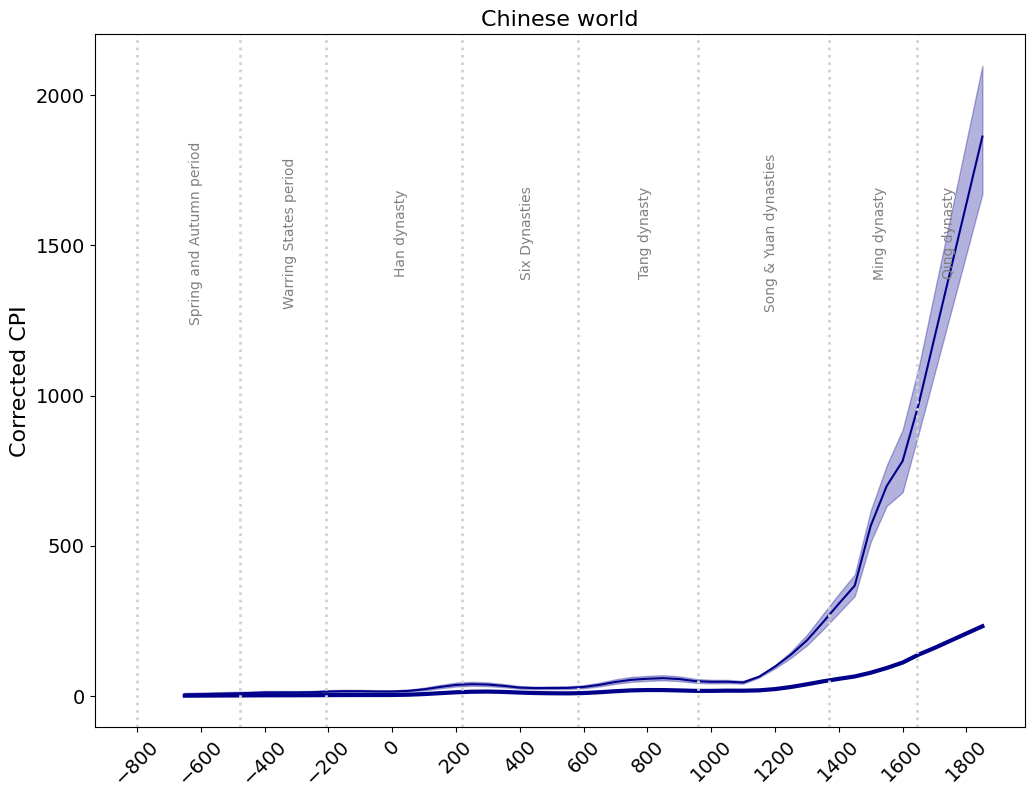

In [41]:
plot_figure(region_name, max_year, min_year,
             period_data=chinese_period_data, 
             year_step = 200, 
             plot_original_trend = True, fifty=True, frac=0.2, plot_names = False, log=False, legend=True)


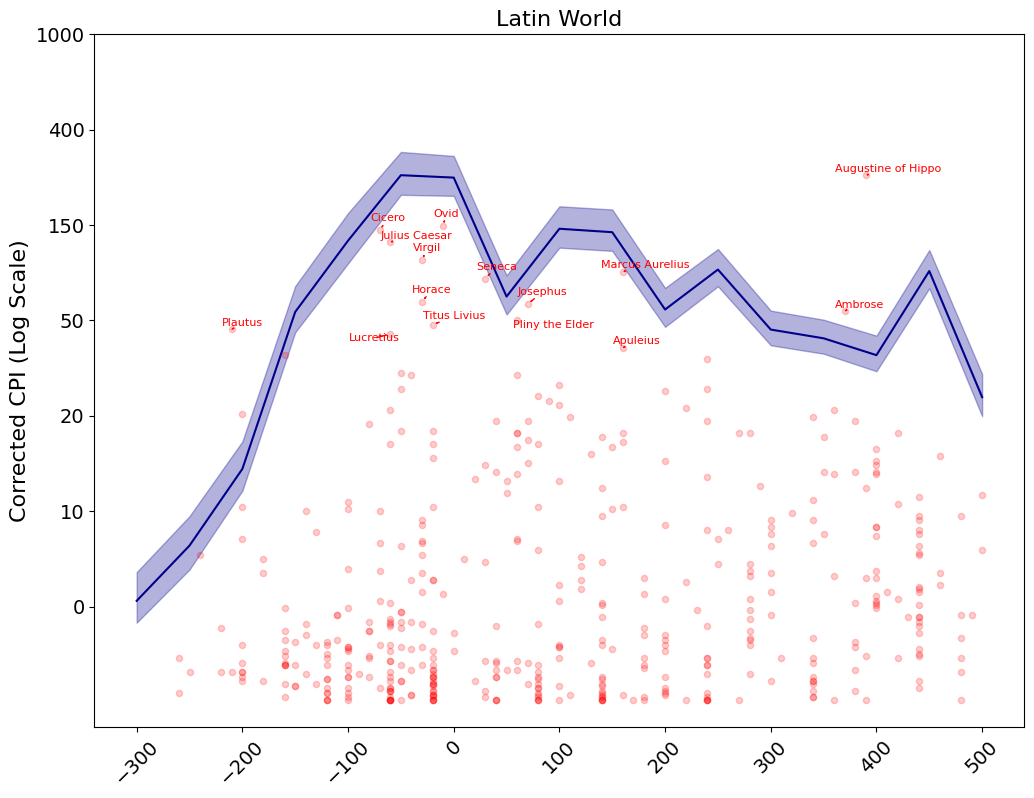

In [42]:
plot_figure(region_name = 'Latin World', min_year = -300, 
            max_year = 500, period_data = None,  year_step = 100, frac=0.15, plot_bars = False, plot_original_trend = False, fifty=True)

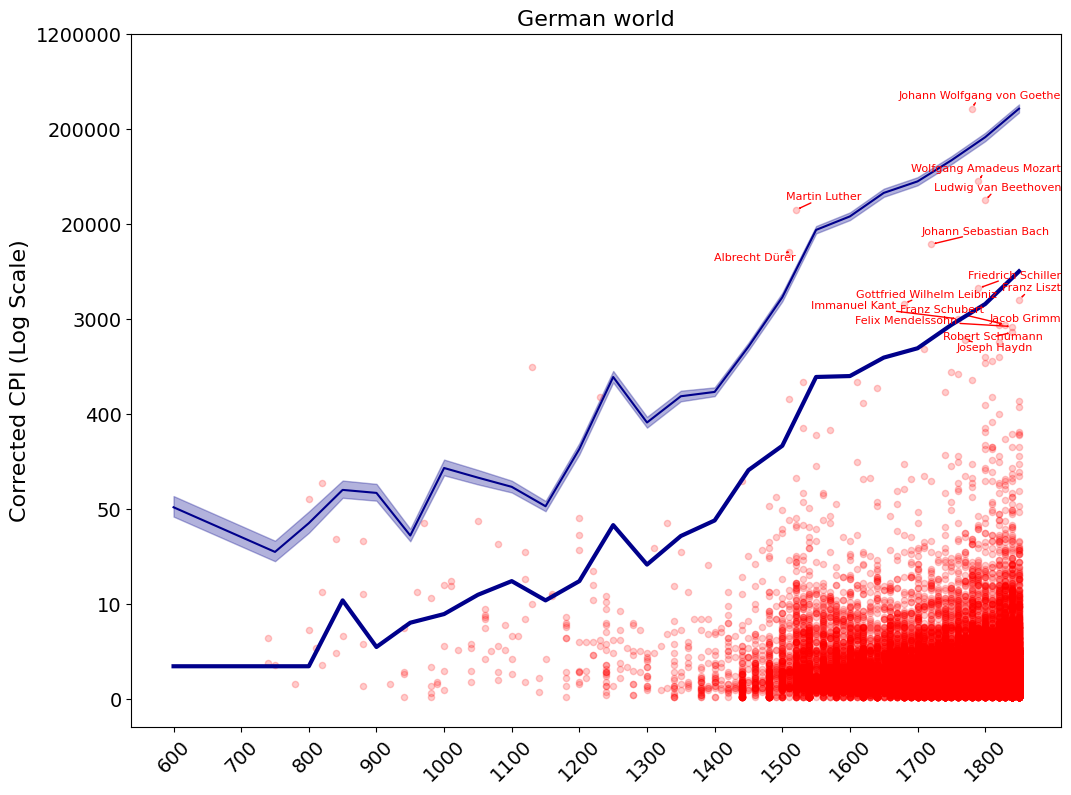

In [66]:
plot_figure(region_name = 'German world', min_year = 600, 
            max_year = 1850, period_data = None,  year_step = 100, frac=0.15, plot_bars = False, plot_original_trend = True, fifty=True)

In [44]:
list(set(df_cultura['region_name']))

['Indian world',
 'Northwestern Europe',
 'Southern Japan',
 'Nordic countries',
 'France',
 'Spain',
 'Latin World',
 'Japan',
 'East Slavic',
 'Korea',
 'Central Europe',
 'Northern China',
 'Arabic world',
 'Persian world',
 'United Kingdom',
 'Greek World',
 'German world',
 'Portugal',
 'Southern China',
 'Southwestern Europe',
 'Italy',
 'Low countries',
 'Chinese world',
 'Northern Japan']

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx an

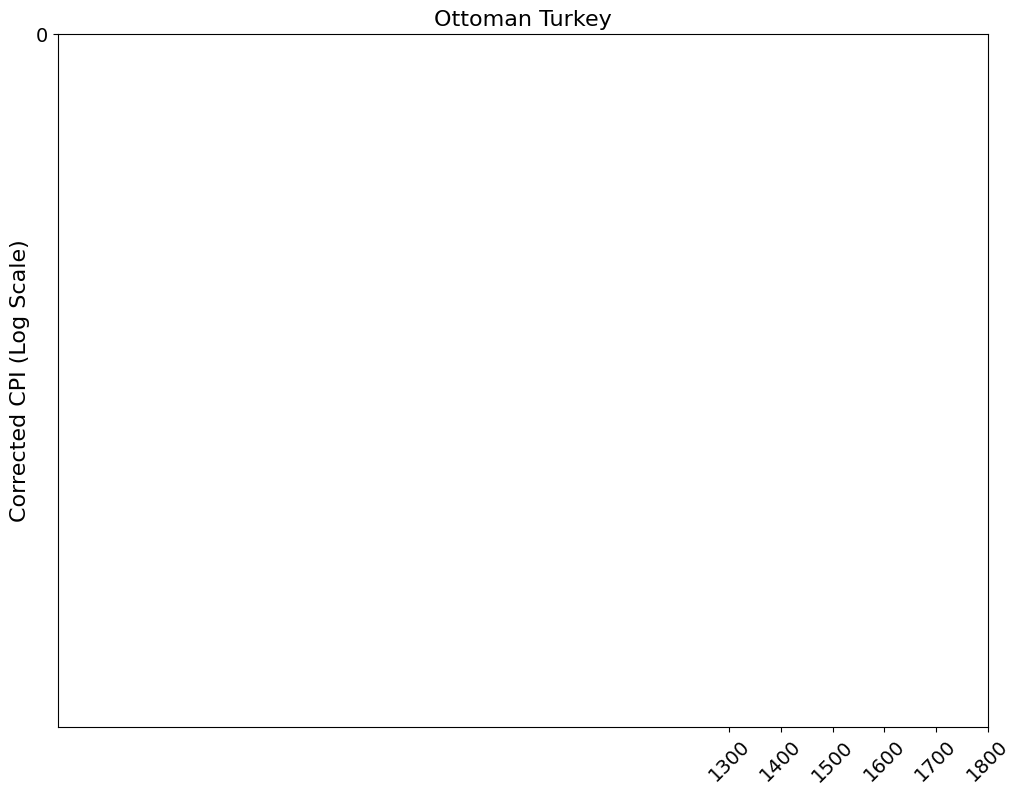

In [45]:
plot_figure(region_name = 'Ottoman Turkey', min_year = 1300, 
            max_year = 1850, period_data = None,  year_step = 100, frac=0.2, plot_bars = False, plot_original_trend = True, fifty=True)

In [46]:
df_individuals[df_individuals['region_name']=='Nordic countries'].sort_values('decade')

,individual_wikidata_id,productive_year,decade,individual_name,score,region_name
82846,Q1402591,586.0,590,Ohthere,3,Nordic countries
106547,Q15661609,829.0,830,Brúni hvíti Háreksson,1,Nordic countries
258930,Q2628262,845.0,840,Hastein,5,Nordic countries
240836,Q2367169,835.0,840,Bragi Boddason,13,Nordic countries
130540,Q16782546,853.0,850,Þórólfur Þorsteinsson,1,Nordic countries
...,...,...,...,...,...,...
497745,Q6228296,1884.0,1880,Jonas Wærn,2,Nordic countries
497742,Q6228261,1881.0,1880,Thorsten Waenerberg,10,Nordic countries
127914,Q16650323,1880.0,1880,Nils Selander,10,Nordic countries
311285,Q31684815,1883.0,1880,Alfvar Theodorik Segerdahl,1,Nordic countries


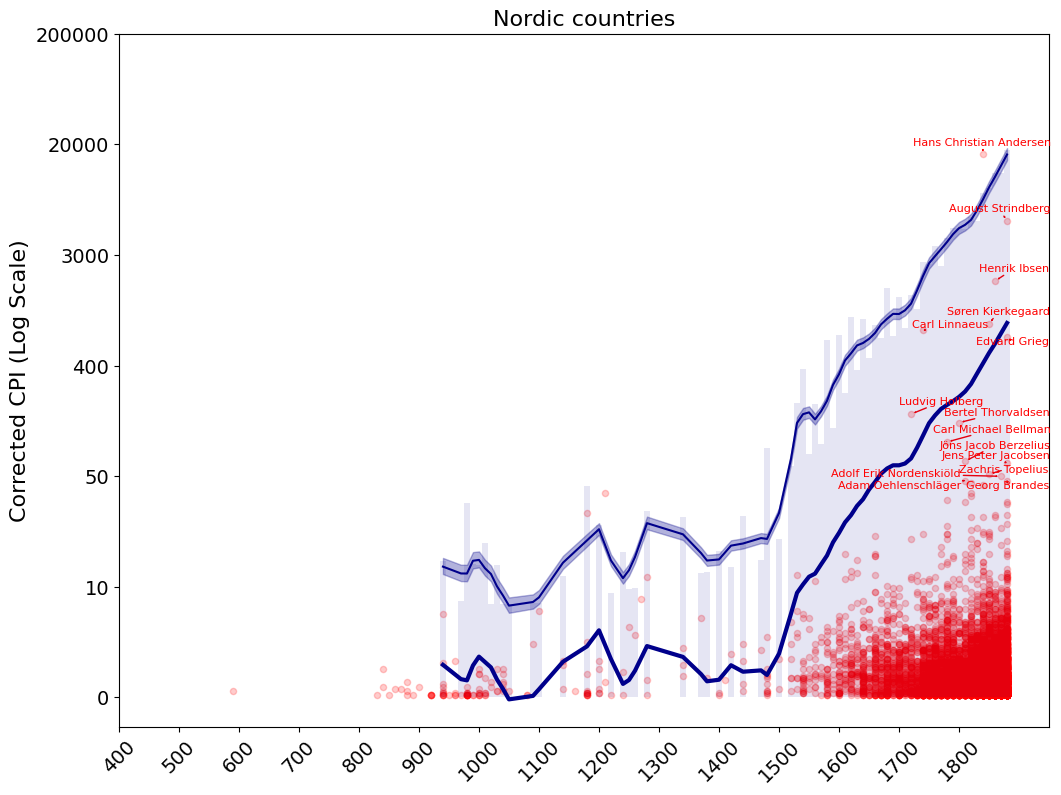

In [47]:
plot_figure(region_name = 'Nordic countries', min_year = 400, max_year = 1880,period_data = None,  year_step = 100, frac=0.1, plot_bars = True,  plot_original_trend = True,)

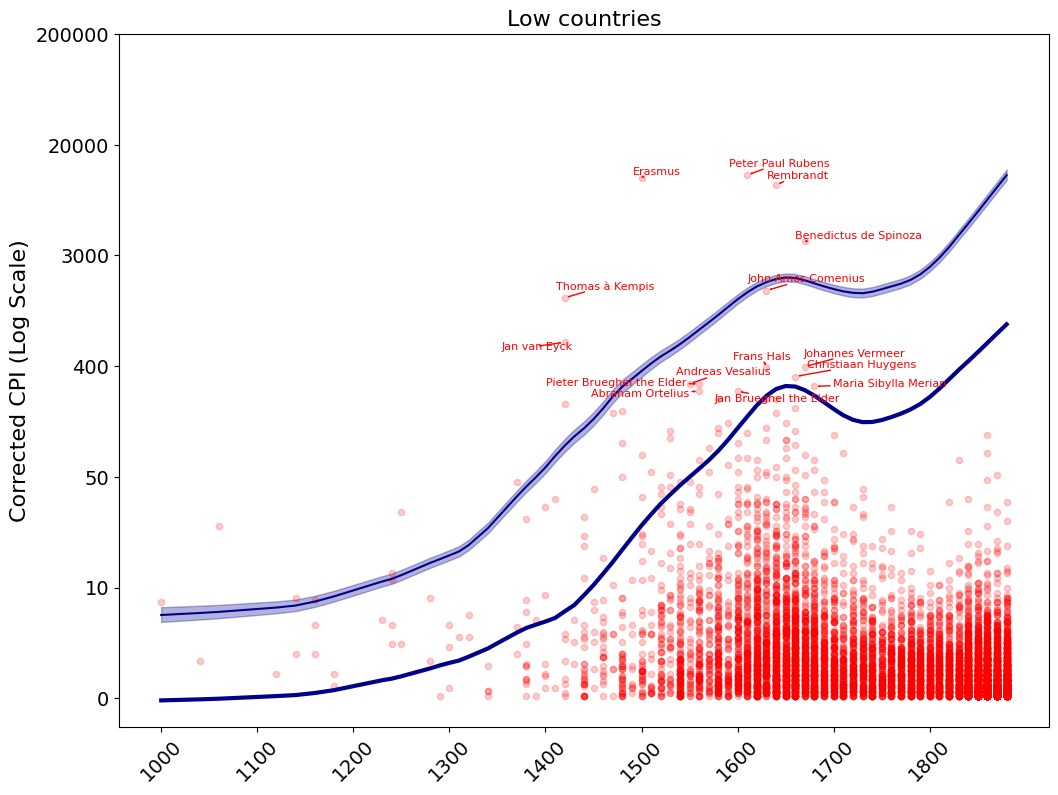

In [48]:
plot_figure(region_name = 'Low countries', min_year = 1000, max_year = 1880,period_data = None,  year_step = 100, frac=0.2,  plot_original_trend = True,
             yticks = [5, 10, 50, 100, 500, 1000, 2000, 5000, 10000, 20000])

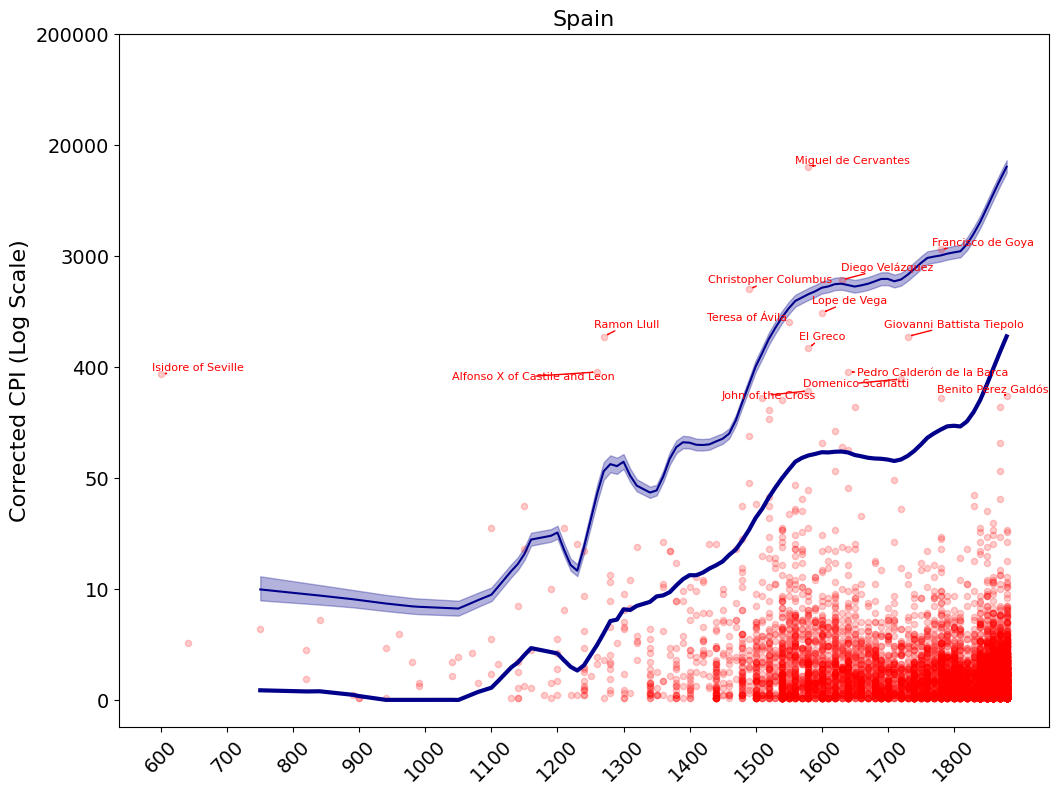

In [49]:
plot_figure(region_name = 'Spain', min_year = 600, max_year = 1880,period_data = None,  year_step = 100,  plot_original_trend = True,
             yticks = [5, 10, 50, 100, 500, 1000, 2000, 5000, 10000, 20000])

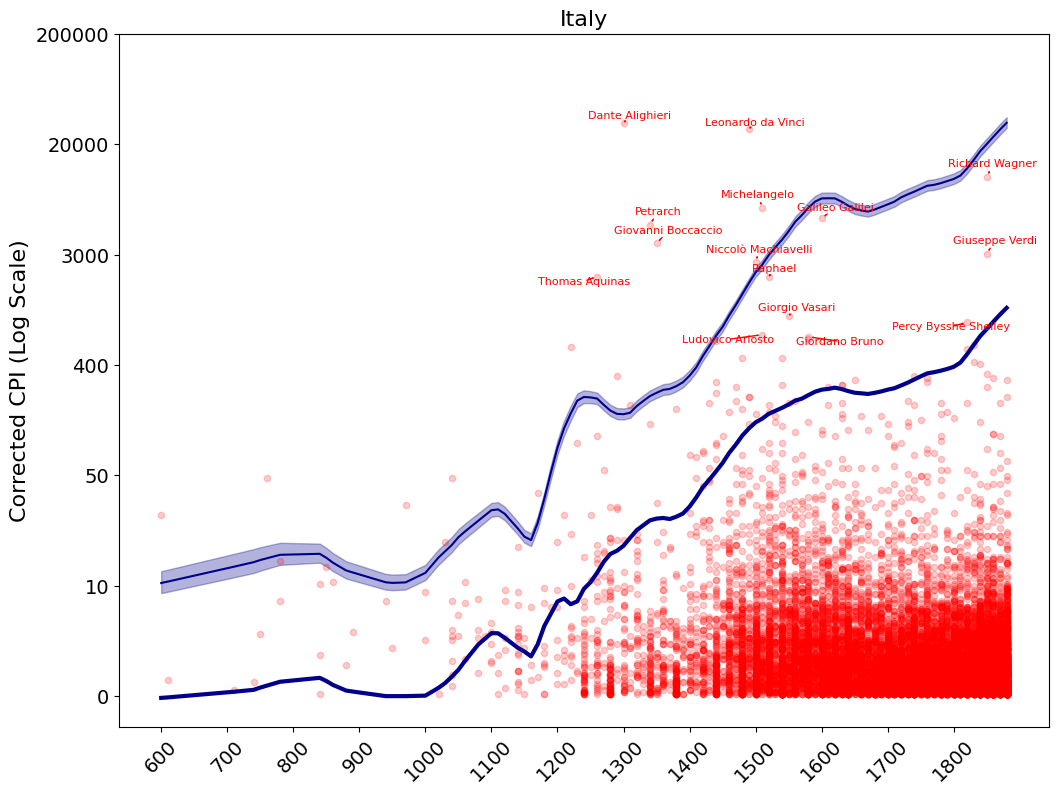

In [50]:
plot_figure(region_name = 'Italy', min_year = 600, max_year = 1880,period_data = None,  year_step = 100,  plot_original_trend = True,
             yticks = [5, 10, 50, 100, 500, 1000, 2000, 5000, 10000, 20000, 50000])

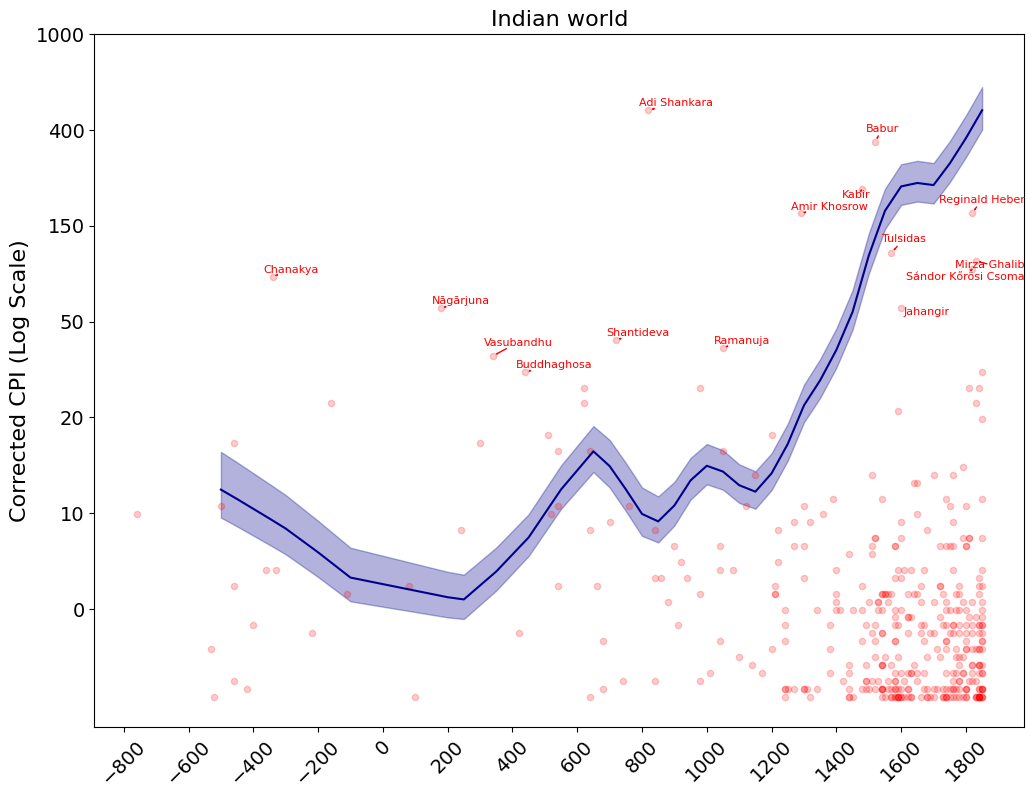

In [51]:
plot_figure(region_name = 'Indian world', min_year = -800, max_year = 1850,period_data = None,  fifty = True, year_step = 200, plot_original_trend = False, frac=0.2)

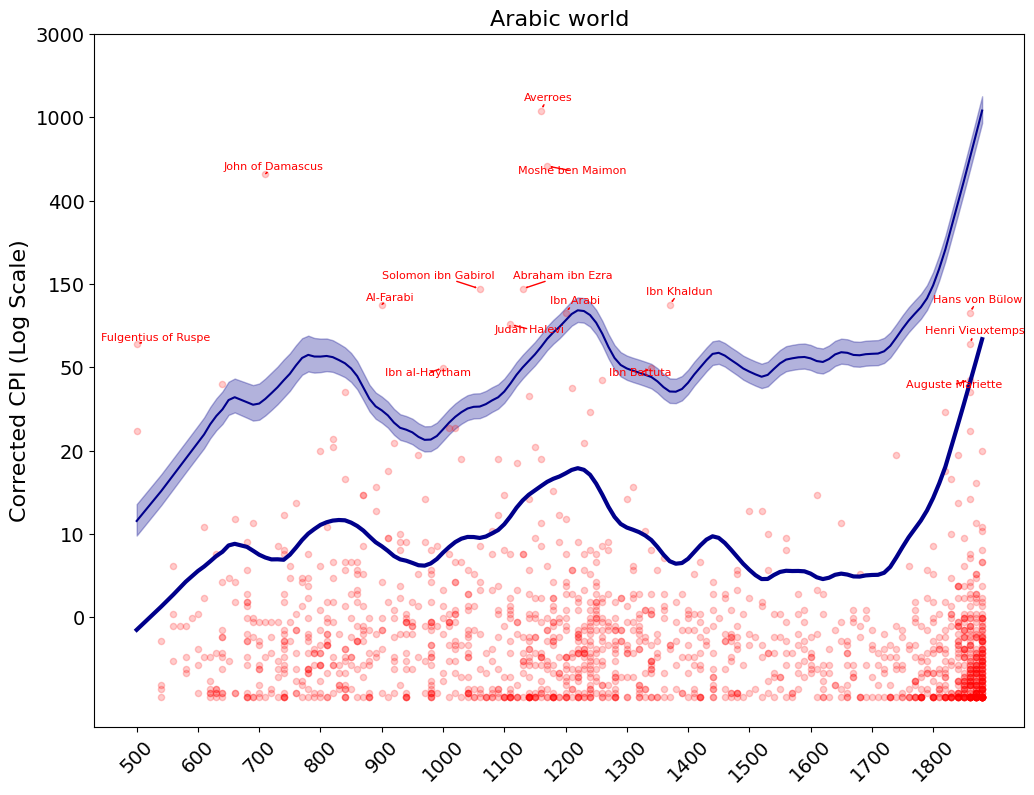

In [52]:
plot_figure(region_name = 'Arabic world', min_year = 500, max_year = 1880,period_data = None,  year_step = 100,  plot_original_trend = True)

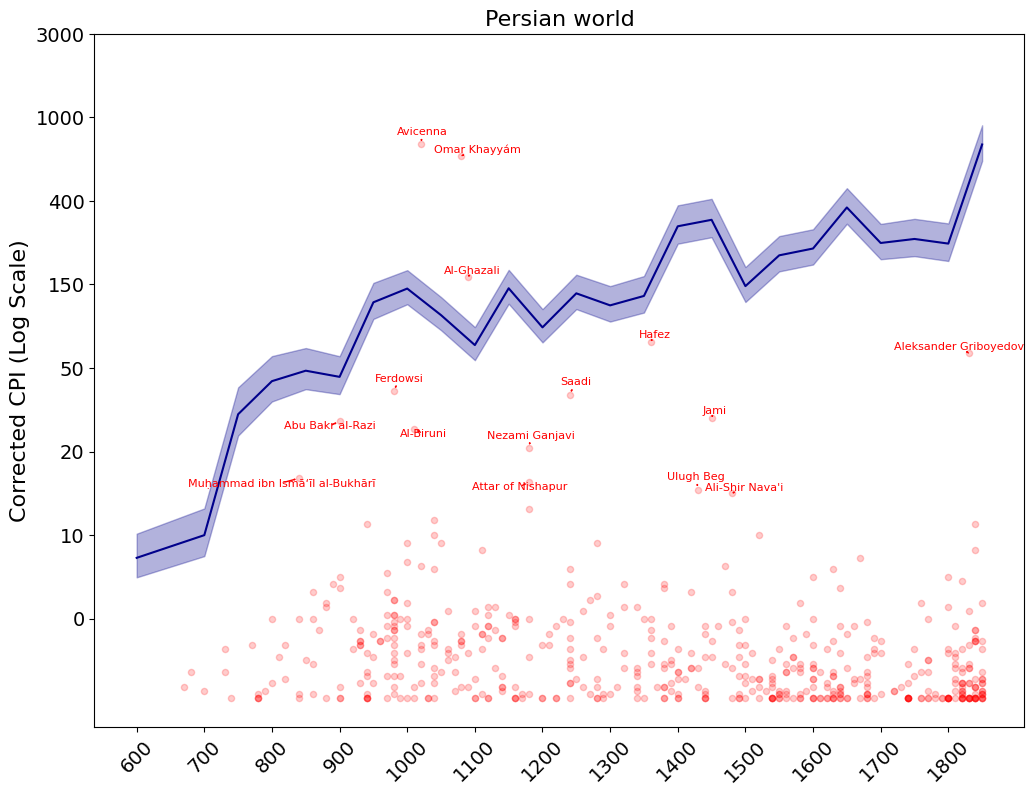

In [53]:
plot_figure(region_name = 'Persian world', min_year = 600, max_year = 1850,period_data = None,  year_step = 100, fifty=True, frac=0.1)

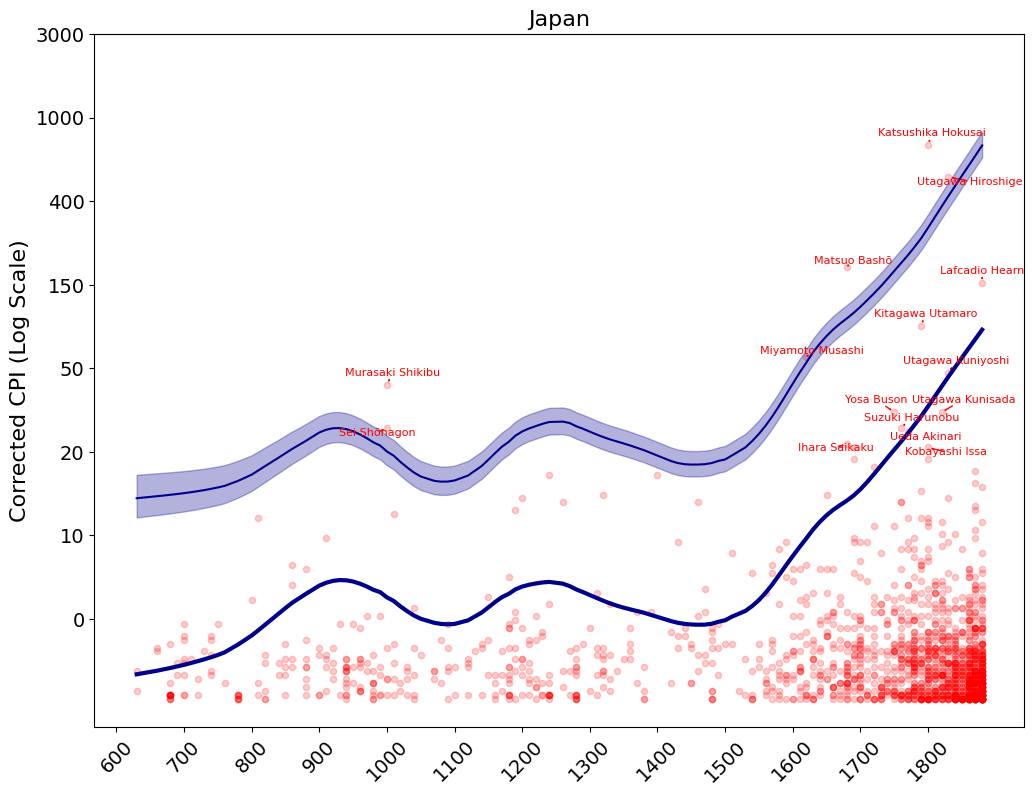

In [54]:
plot_figure(region_name = 'Japan', min_year = 600, max_year = 1880,period_data = None,  year_step = 100,  plot_original_trend = True, frac = 0.2)

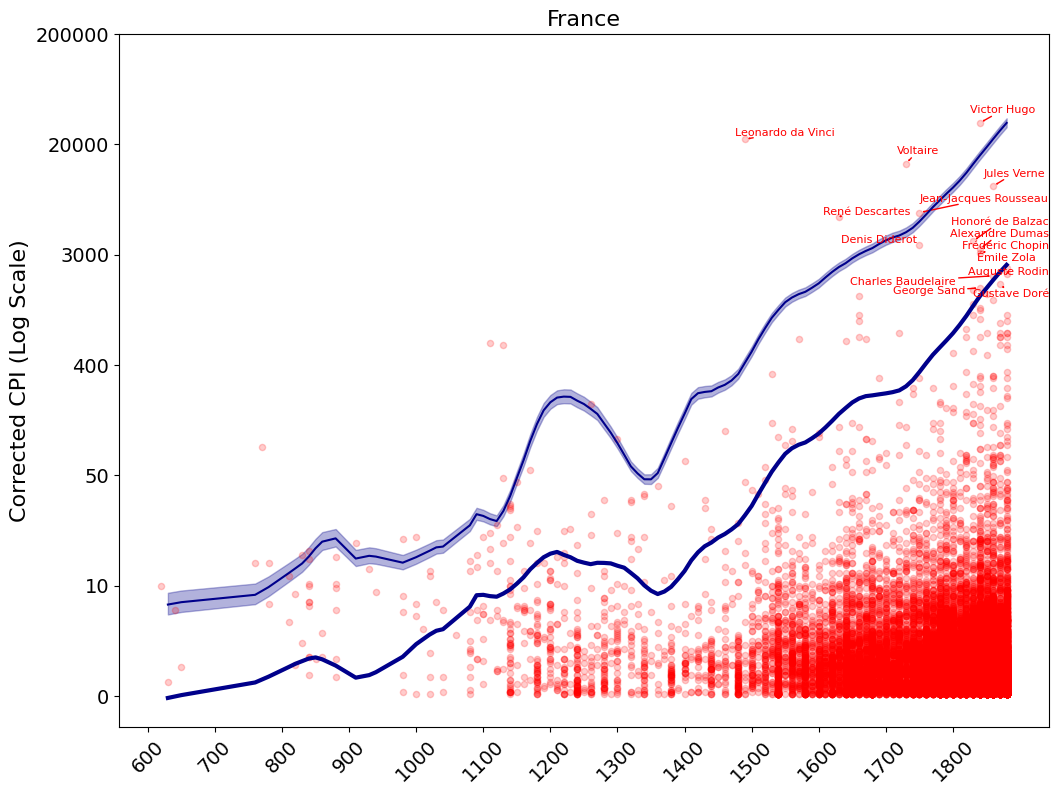

In [55]:
plot_figure(region_name = 'France', min_year = 600, max_year = 1880,period_data = None,  year_step = 100,  plot_original_trend = True,
             yticks = [5, 10, 50, 100, 500, 1000, 2000, 5000, 10000, 20000, 50000])

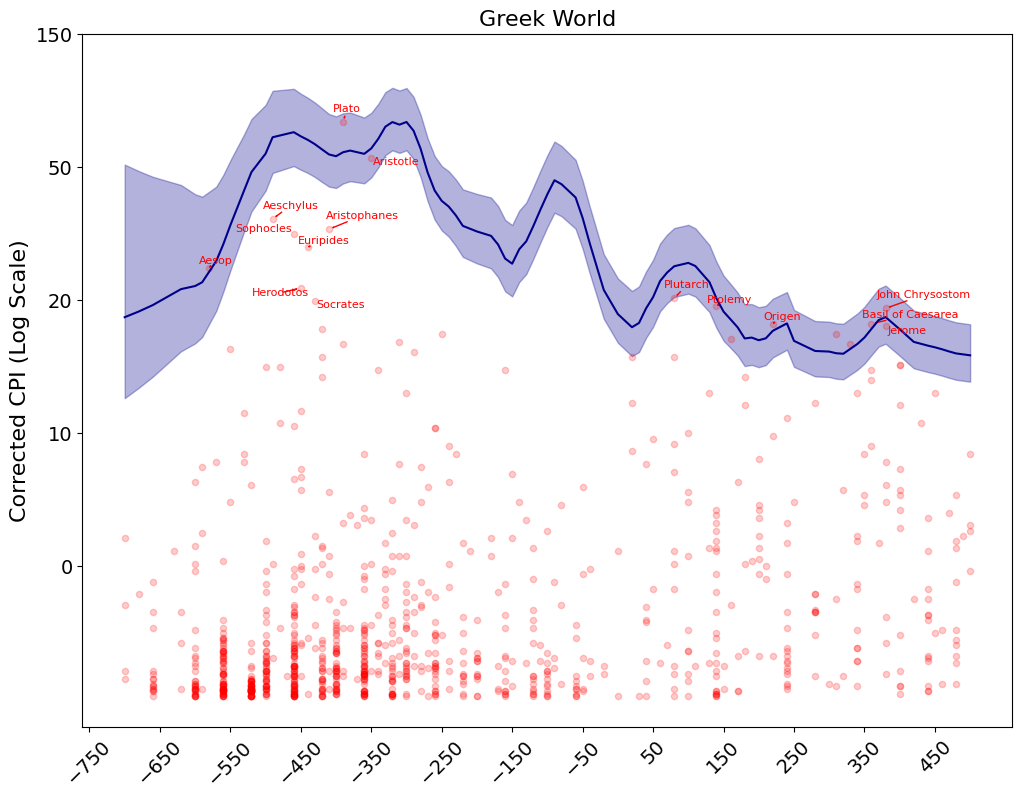

In [56]:
plot_figure(region_name = 'Greek World', min_year = -750, max_year = 500,period_data = None,  year_step = 100, frac = 0.15,  plot_original_trend = False)

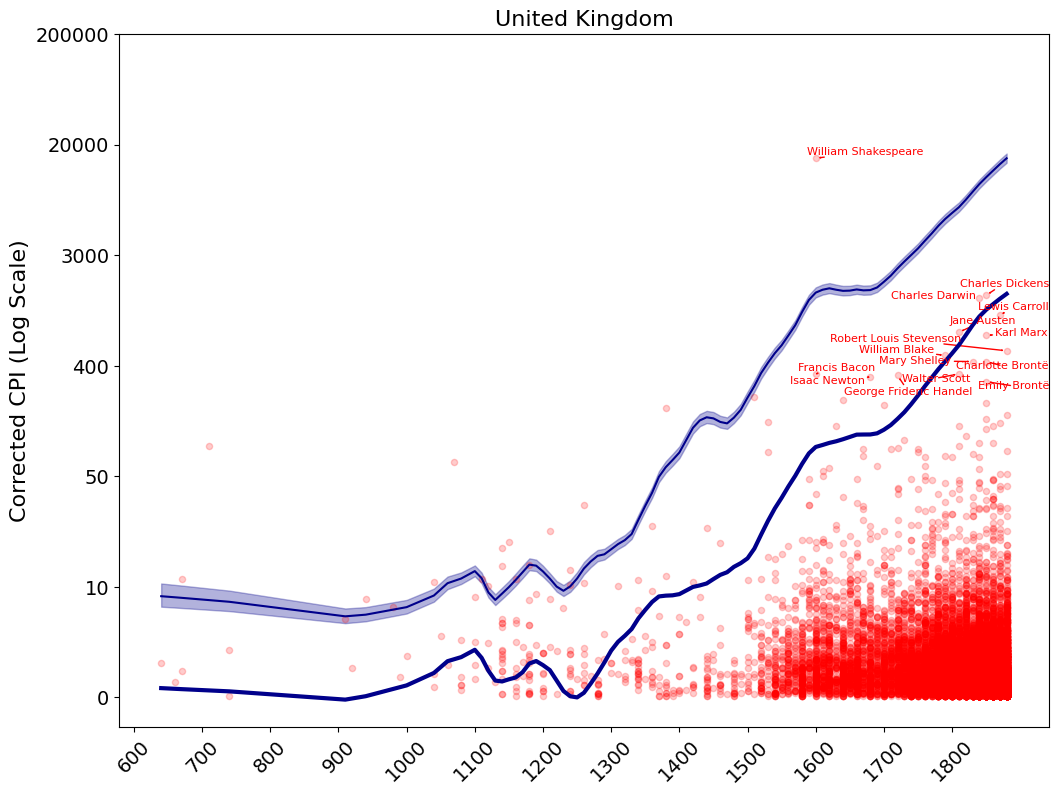

In [57]:
plot_figure(region_name = 'United Kingdom', min_year = 600, max_year = 1880,period_data = None,  year_step = 100,  plot_original_trend = True,
             yticks = [5, 10, 50, 100, 500, 1000, 2000, 5000, 10000, 20000, 50000])

### Plot 2 figures

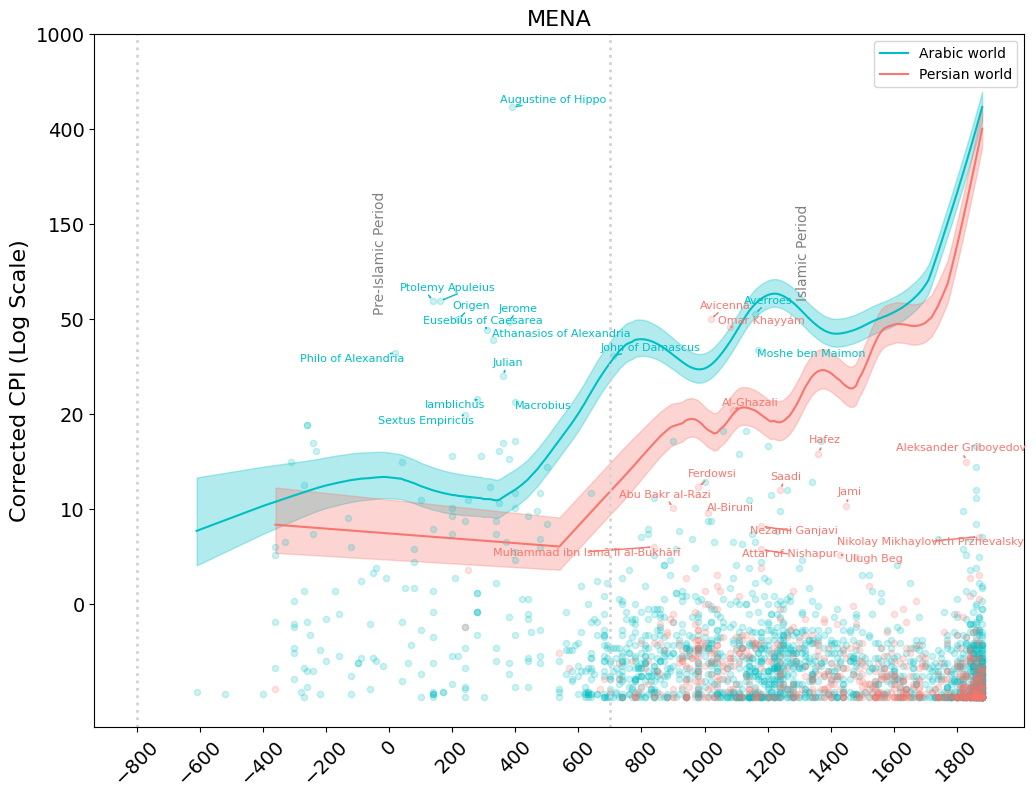

In [58]:
def plot_figures(region_name_1, 
                 region_name_2,
                    max_year, 
                    min_year, 
                    period_data, 
                    title,
                    year_step = 200, 
                    plot_names = True, 
                    frac = 0.1, 
                    top_n_individuals = 15,
                    plot_bars = False,
                    plot_original_trend = False,
                    fifty=False
                    ):




    
    df = df_cultura[df_cultura['region_name'].isin([region_name_1, region_name_2])]


    if fifty:
        df['decade'] = df['decade'].apply(lambda x: int(x) + (50 - int(x) % 50))
        df = df.groupby(['region_name', 'decade']).sum().reset_index()


    df = df[(df['decade'] <=max_year) & (df['decade']>=min_year)]

    df['N_est'] = np.log(df['N_est'])  # Applying log transformation
    df['N_est_min'] = np.log(df['N_est_min'])  # Min bound log
    df['N_est_max'] = np.log(df['N_est_max'])  # Max bound log
    df['score'] = np.log(df['score'])  # Max bound log



    df_individuals_filtered = df_individuals[(df_individuals['decade']<=max_year)&(df_individuals['decade']>=min_year)]
    df_individuals_filtered = df_individuals_filtered[df_individuals_filtered['region_name'].isin([region_name_1, region_name_2])]
    # Define your color scheme
    colors = {
        region_name_1: "#00bfc4",
        region_name_2: "#f8766d"
    }

    fig, ax = plt.subplots(figsize=(12, 9))


    # List for storing text annotations for later adjustment
    texts = []

    # Calculate the maximum smoothed value for normalization
    max_n_est = float('-inf')

    # Adding smoothing and plotting for each region
    for region in df['region_name'].unique():
        region_data = df[df['region_name'] == region]
        region_data.sort_values(by='decade', inplace=True)


        # LOESS smoothing
        smoothed = lowess(region_data['N_est'], region_data['decade'], frac=frac)
        smoothed_min = lowess(region_data['N_est_min'], region_data['decade'], frac=frac)
        smoothed_max = lowess(region_data['N_est_max'], region_data['decade'], frac=frac)

        # Update maximum n_est if current is higher
        max_n_est = max(max_n_est, max(smoothed[:, 1]))

        # Plotting the smoothed mean estimate
        ax.plot(smoothed[:, 0], smoothed[:, 1], label=region, color=colors[region])

        # Plotting the confidence interval as a fill between
        ax.fill_between(smoothed[:, 0], smoothed_min[:, 1], smoothed_max[:, 1], color=colors[region], alpha=0.3)

    # Calculate the maximum score for all individuals for normalization
    max_global_score = df_individuals_filtered['score'].max()


    if plot_original_trend:

            # Adding smoothing and plotting for each region
        for region in df['region_name'].unique():
            region_data = df[df['region_name'] == region]
            region_data.sort_values(by='decade', inplace=True)

                    # LOESS smoothing
            smoothed = lowess(region_data['score'], region_data['decade'], frac=frac)
            # smoothed_min = lowess(region_data['N_est_min'], region_data['decade'], frac=0.2)
            # smoothed_max = lowess(region_data['N_est_max'], region_data['decade'], frac=0.2)

            # Update maximum n_est if current is higher
            max_n_est = max(max_n_est, max(smoothed[:, 1]))

            # Plotting the smoothed mean estimate
            ax.plot(smoothed[:, 0], smoothed[:, 1], label=region, color=colors[region], linewidth = 3,linestyle='-')


    if plot_names:
        # Collect texts from each region separately and adjust
        for region in df_individuals_filtered['region_name'].unique():
            region_individuals = df_individuals_filtered[df_individuals_filtered['region_name'] == region]
            region_individuals = region_individuals.sort_values('score', ascending=False)
            top_individuals = region_individuals.head(top_n_individuals).sort_values('score', ascending=False)
            texts = []  # Initialize a new list for this region's texts

            # Plot scatter for all individuals
            all_scores_normalized = (region_individuals['score'] / max_global_score) * max_n_est
            ax.scatter(region_individuals['decade'], all_scores_normalized, color=colors[region], alpha=0.2, s=20)

            # Texts for top 15
            for _, row in top_individuals.iterrows():
                score_normalized = (row['score'] / max_global_score) * max_n_est
                text = ax.text(row['decade'], score_normalized, row['individual_name'], 
                            ha='center', va='bottom', color=colors[region],fontsize=8)
                texts.append(text)

            # Use adjust_text for the current region with the corresponding arrow color
            adjust_text(texts, arrowprops=dict(arrowstyle="->", color=colors[region]))

    

    if period_data:
        # Adding labels and vertical lines for each period
        for intercept, label in zip(period_data['x_intercepts'], period_data['labels']):
            start, end = intercept
            midpoint = (start + end) / 2  # Calculate the midpoint of each period
            
            # Add vertical line at the start of each period
            ax.axvline(x=start, color='lightgrey', linestyle='dotted', linewidth=2)
            
            # Add text label at the midpoint of the period, shifted upwards
            ax.text(midpoint, ax.get_ylim()[1] * 0.7, label, rotation=90, verticalalignment='center', fontsize=10, color='grey')



    if plot_bars:
        # Plot bars from the real values
        for region in df['region_name'].unique():
            region_data = df[df['region_name'] == region]
            region_data.sort_values(by='decade', inplace=True)
            # Bars representing the scores
            ax.bar(region_data['decade'], region_data['N_est'], label=region, color=colors[region], width=10, alpha = 0.2, zorder=2)


    # # Define specific y-ticks and convert them to log scale for plotting
    # yticks = [5, 10, 50, 100, 500, 1000, 2000]
    # yticks_log = np.log(yticks)  # Convert yticks to their logarithmic values

    # ax.set_yticks(yticks_log)  # Set the logarithmic y-ticks
    # ax.set_yticklabels([str(y) for y in yticks])  # Use original y-tick labels


     # Get current y-axis ticks (which are in log scale)
    ticks_log = ax.get_yticks()

    # Calculate the original values from the log scale ticks
    ticks_original = np.exp(ticks_log)  # Adjust if a different base is used for logging

    # Round to the nearest 10

    ticks_rounded = [custom_round(tick) for tick in ticks_original]

    #ticks_rounded = np.around(ticks_original / 10) * 10

    # Remove duplicates, keeping only the last occurrence
    unique_ticks = {}
    for tick, original in zip(ticks_rounded, ticks_log):
        unique_ticks[tick] = original  # This will overwrite the tick with its last occurrence

    # Now, set the ticks and labels, skipping duplicates
    final_ticks = sorted(unique_ticks.items())  # Sort ticks by their values
    ax.set_yticks([item[1] for item in final_ticks])  # Set the unique tick positions
    ax.set_yticklabels(['{:.0f}'.format(item[0]) for item in final_ticks])  # Set the unique tick labels



    # Set the size of x-axis and y-axis tick labels
    ax.tick_params(axis='x', labelsize=14)  # Increase x-axis tick label size
    ax.tick_params(axis='y', labelsize=14)  # Increase y-axis tick label size

    ax.set_xticks(np.arange(min_year, max_year + 1, year_step))  # Set x-ticks every 200 years
    # Rotating x-ticks by 45 degrees for better readability
    ax.tick_params(axis='x', rotation=45)
    ax.set_xlabel('')
    ax.set_ylabel('Corrected CPI (Log Scale)', fontsize = 16)
    ax.set_title(title, fontsize = 16)
    ax.legend()
    plt.show()


plot_figures(region_name_1="Arabic world", 
        region_name_2='Persian world',
            max_year = 1880, 
            min_year = -800, 
            title='MENA',
            period_data = {
            "x_intercepts": [
                [-800, 700],
                [700, 1880],
            
            ],
            "labels": [
                "Pre-Islamic Period",
                "Islamic Period",
            ]
        }, 
            year_step = 200, 
            plot_names = True, 
            frac = 0.2, 
            top_n_individuals = 15,
            plot_bars = False,
            plot_original_trend = False)

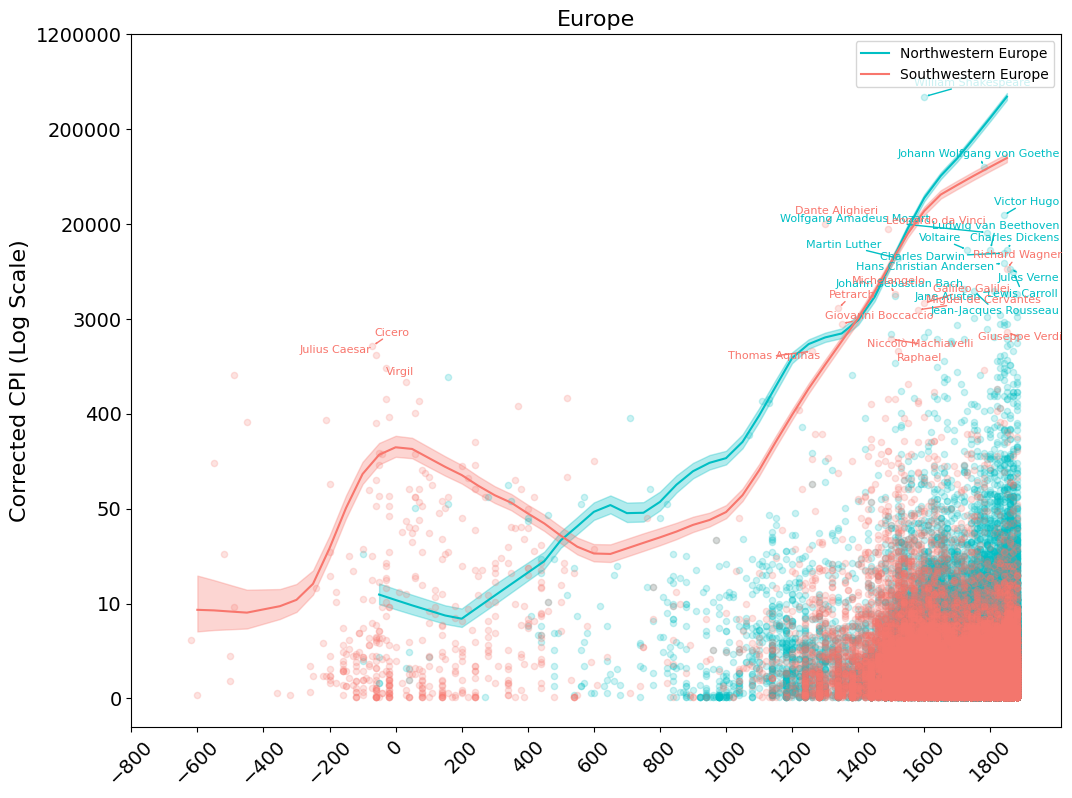

In [59]:
plot_figures(region_name_1="Northwestern Europe", 
        region_name_2='Southwestern Europe',
            max_year = 1880, 
            min_year = -800, 
            title='Europe',
            period_data = None, 
            year_step = 200, 
            plot_names = True, 
            frac = 0.2, 
            top_n_individuals = 15,
            plot_bars = False,
            plot_original_trend = False, fifty = True)

In [60]:
list(set(df_cultura.region_name))

['Indian world',
 'Northwestern Europe',
 'Southern Japan',
 'Nordic countries',
 'France',
 'Spain',
 'Latin World',
 'Japan',
 'East Slavic',
 'Korea',
 'Central Europe',
 'Northern China',
 'Arabic world',
 'Persian world',
 'United Kingdom',
 'Greek World',
 'German world',
 'Portugal',
 'Southern China',
 'Southwestern Europe',
 'Italy',
 'Low countries',
 'Chinese world',
 'Northern Japan']

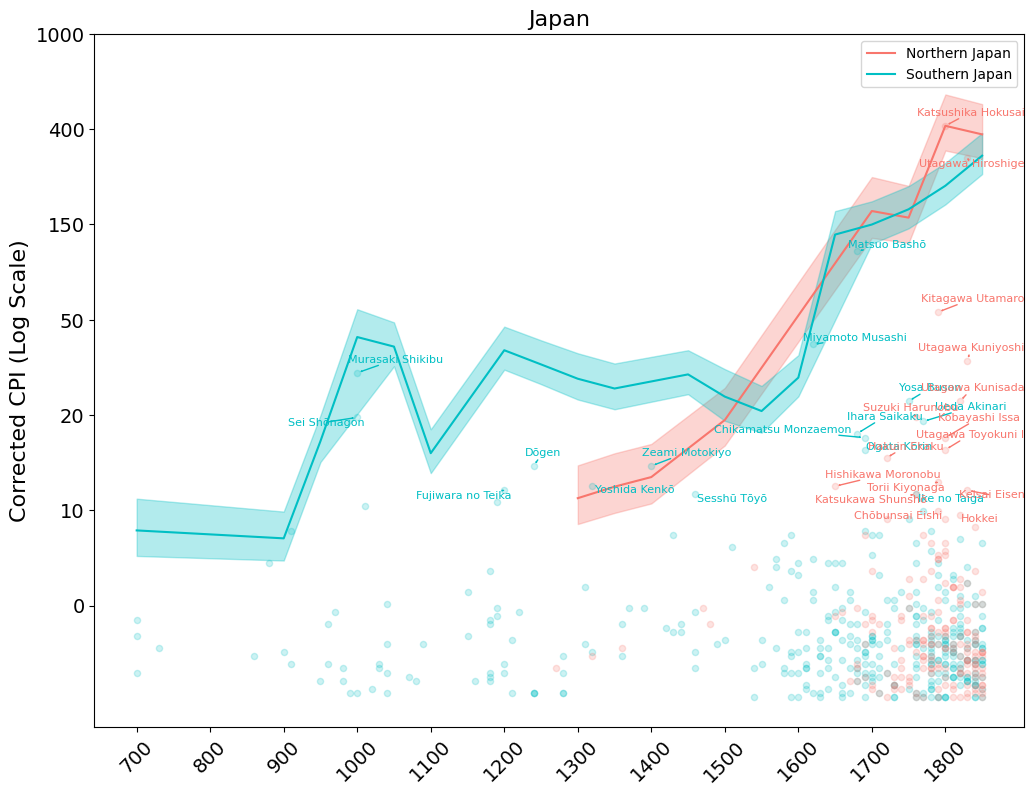

In [61]:
plot_figures(region_name_1="Southern Japan", 
        region_name_2="Northern Japan",
            max_year = 1850,
            min_year = 700, 
            title='Japan',
            period_data =None, 
            year_step = 100, 
            plot_names = True, 
            frac = 0.2, 
            top_n_individuals = 15,
            plot_bars = False,
            plot_original_trend = False, 
            fifty = True)

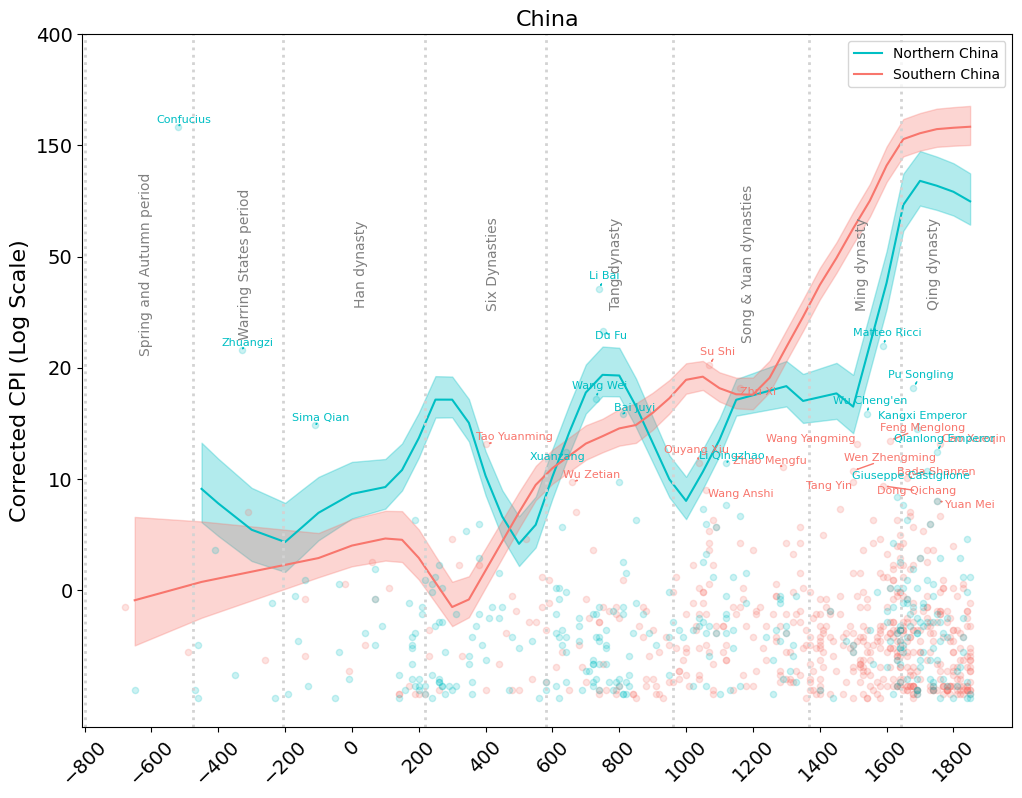

In [62]:
plot_figures(region_name_1="Northern China", 
        region_name_2='Southern China',
            max_year = 1850, 
            min_year = -800, 
            title='China',
            period_data =chinese_period_data, 
            year_step = 200, 
            plot_names = True, 
            frac = 0.2, 
            top_n_individuals = 15,
            plot_bars = False,
            plot_original_trend = False, 
            fifty = True)

In [63]:
list(set(df_cultura.region_name))

['Indian world',
 'Northwestern Europe',
 'Southern Japan',
 'Nordic countries',
 'France',
 'Spain',
 'Latin World',
 'Japan',
 'East Slavic',
 'Korea',
 'Central Europe',
 'Northern China',
 'Arabic world',
 'Persian world',
 'United Kingdom',
 'Greek World',
 'German world',
 'Portugal',
 'Southern China',
 'Southwestern Europe',
 'Italy',
 'Low countries',
 'Chinese world',
 'Northern Japan']

### Plot Western Europe

In [64]:
plot = False

if plot:

    from dotenv import load_dotenv
    import sqlite3
    import os

    load_dotenv()

    DB_PATH = os.getenv("DB_PATH")

    conn = sqlite3.connect(DB_PATH)
    cursor = conn.cursor()

    df_western = df_cultura_original.copy()

    df_country = pd.read_sql_query("SELECT * FROM individuals_main_information", conn)
    df_country = df_country[df_country['country_name'].isin(['Tunisia', 'Morocco', 'Algeria'])]
    df_country = df_country[df_country['birthyear']<=535]

    df_western = df_western[~df_western['individual_wikidata_id'].isin(list(df_country['individual_wikidata_id']))]


    # remove individuals belonging to #before 500 to Tunisia, Morocco and Algeria

    df_western['N_est'] = df_western['f0'] + df_western['f1'] + df_western['f2']# plus the individual
    df_western['N_est_min']  =  df_western['min_f0'] + df_western['f1'] + df_western['f2']# plus the individual
    df_western['N_est_max']  =  df_western['max_f0'] + df_western['f1'] + df_western['f2']# plus the individual

    df_cultura = df_western.groupby(['region_name', 'decade']).agg({'N_est': 'sum', 'N_est_min':'sum', 'N_est_max':'sum', 'individual_wikidata_id':'count'}).reset_index()
    df_cultura = df_cultura.rename(columns={"individual_wikidata_id": "score"})

    # Load individuals Data
    df_individuals = pd.read_csv('/Users/charlesdedampierre/Desktop/cultura_project/immaterial_index/results/df_individuals_score.csv', index_col = [0])


    # Add indiviudals not taken into account into the unseen-species model
    df_works = pd.read_csv('db_extract/df_indi__work>2.csv', index_col=[0])
    df_works = df_works.groupby(['decade', 'region_name'])['individual_wikidata_id'].count().reset_index()
    df_works = df_works.rename(columns = {'individual_wikidata_id':'f>3'})

    df_cultura = pd.merge(df_cultura, df_works, on = ['region_name', 'decade'], how='left')
    df_cultura = df_cultura.fillna(0)


    df_cultura['N_est'] = df_cultura['N_est'] + df_cultura['f>3']
    df_cultura['N_est_min'] = df_cultura['N_est_min'] + df_cultura['f>3']
    df_cultura['N_est_max'] = df_cultura['N_est_max'] + df_cultura['f>3']
    df_cultura['score'] = df_cultura['score'] + df_cultura['f>3']



    regions_eu = ['Latin World',
    'Portugal',
    'Italy',
    #  'Greek World',
    'Spain',
    'Nordic countries',
    'German world',
    'Low countries',
    'France',
    'United Kingdom']

    df_cultura = df_cultura[df_cultura['region_name'].isin(regions_eu)]
    df_cultura['region_name'] = 'Western Europe'

    plot_figure(region_name = 'Western Europe', min_year = -800, max_year = 1850, period_data = None,  year_step = 100,  plot_original_trend = False, fifty=True)

In [65]:
# or just add Italy, France

# British Islands (After 500 CE)
# France (After 500 CE)
# German world (After 500 CE)
# Portugal (After 500 CE)
# Spain (after 500 CE)
# Italy (after 500 CE)
# Low countries (After 500 CE)
# Nordic countries (After 500 CE)